# TfIdf analysis on Sumerian literary compositions addressed to the Sun god Utu
## Introduction
The present project aims to compare different literary corpora in order to identify their distinctive features, in this case, different literary motives. Different literary genres were defined as such according to ancient definitions, but the rationale beyond this emic classification remains often obscure to the modern reader.

Sumerian is the oldest known language of humankind, it was spoken in Mesopotamia (today Iraq) in the third millennium BCE, and it was used as a scholarly and literary language (in a similar way to Latin in modern Europe) until the first century BCE.

Different kinds of prayers addressed to the Sun god Utu are attested in Sumerian literature among various literary genres. The Kiutu prayers constitute one of these genres, which I studied during my Ph.D. thesis (Baragli 95). The texts of this corpus were called by the Mesopotamians ki-$^{d}$utu, which literally means "place of the Sun (god)": they are incantation prayers since they express a wish and have a ritual background. Since Kiutu designates the ancient emic label of such literary genre, my research question during the study of this genre was: “which are the distinctive features of a Kiutu?” 

In order to answer this question, I'll investigate the role that Utu plays in different literary genres with computational literary analysis. Therefore, the research question is the following: "does the Sun god play a different role among different literary genres, which concern him?"

## 1. Extracting Data from JSON Files
There are currently some ongoing projects working on online databases, lemmatization and data analysis of Sumerian. The most important is ORACC ("The Open Richly Annotated Cuneiform Corpus"), whose goal is the online publication of lemmatized texts arranged into several corpora (http://oracc.museum.upenn.edu/). For the present paper, I extracted the texts from two projects: ETCSL ("The Electronic Text Corpus of Sumerian Literature", http://build-oracc.museum.upenn.edu/epsd2/literary/pager, and the Kiutu-project.

The project ETCSL, whose former website was http://etcsl.orinst.ox.ac.uk/ is far to be complete, but it represents the most important turning point in the digitization of Sumerian literary texts. Each text is accompanied by translations. 
The latter is the online database of the Kiutus, based on an ORACC format, to which I contributed. This ORACC project is not yet public.

Since the current format of all ORACC database is JSON, this first part of the code extracts lemmatized data from such files. This process is the standard procedure for manipulating data from ORACC projects, the code is public and accessible here https://github.com/niekveldhuis/compass/blob/master/2_1_Data_Acquisition_ORACC/2_1_3_extended_ORACC-JSON_parser.ipynb.

In [57]:
""" Utilities for Computational Assyriology """
""" All this code is taken from the utilities for Computational Assyriology.
I copied the utilities here, so that it can work on your computer as well.
It needs the extension Jupyter Widgets. """

import requests
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm.auto import tqdm
import os
import errno
import zipfile
import json
import pandas as pd


lemm_l = []
meta_d = {"label": None, "id_text": None}
dollar_keys = ["extent", "scope", "state"]

def make_dirs(x):
    """Check for existence of directories
    create those if they do not exist
    otherwise do nothing. Parameter is a list
    with directory names"""
    for dir in x:
        try:
            os.mkdir(dir)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
            pass

def format_project_list(x):
    p = x.lower().strip().split(',')
    p = [x.strip() for x in p]
    return(p)

def oracc_download(p):
    """Downloads ZIP with JSON files from
    ORACC server. Parameter is a list
    with ORACC project names"""

    CHUNK = 16 * 1024
    p = list(set(p)) #remove duplicates
    projects = p.copy()
    for project in p:
        proj = project.replace('/', '-')
        url = "http://build-oracc.museum.upenn.edu/json/" + proj + ".zip"
        file = 'jsonzip/' + proj + '.zip'
        with requests.get(url, stream=True) as r:
            if r.status_code == 200:
                with open(file, 'wb') as f:
                    for c in tqdm_notebook(r.iter_content(chunk_size=CHUNK), desc = project):
                        f.write(c)
            else:
                print(url + " does not exist.")
                projects.remove(project)
    return projects

def parsejson(text):
    for JSONobject in text["cdl"]:
        if "cdl" in JSONobject: 
            parsejson(JSONobject)
        if "label" in JSONobject:
            meta_d["label"] = JSONobject['label']
        if "type" in JSONobject and JSONobject["type"] == "field-start": # this is for sign lists, identifying fields such as
            meta_d["field"] = JSONobject["subtype"]                    # sign, pronunciation, translation.
        if "type" in JSONobject and JSONobject["type"] == "field-end":
            meta_d.pop("field", None)                           # remove the key "field" to prevent it from being copied 
                                                              # to all subsequent lemmas (which may not have fields)
        if "f" in JSONobject:
            lemma = JSONobject["f"]
            lemma["id_word"] = JSONobject["ref"]
            lemma['label'] = meta_d["label"]
            lemma["id_text"] = meta_d["id_text"]
            if "field" in meta_d:
                lemma["field"] = meta_d["field"]
            lemm_l.append(lemma)
        if "strict" in JSONobject and JSONobject["strict"] == "1":
            lemma = {key: JSONobject[key] for key in dollar_keys}
            lemma["id_word"] = JSONobject["ref"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
    return

def get_lemmas(p):
    for project in p:
        file = "jsonzip/" + project.replace("/", "-") + ".zip"
        try:
            z = zipfile.ZipFile(file) 
        except:
            print(file + " does not exist or is not a proper ZIP file")
            continue
        files = z.namelist()
        files = [name for name in files if "corpusjson" in name and name[-5:] == '.json'] 
        for filename in tqdm_notebook(files, desc = project):
            id_text = project + filename[-13:-5] 
            meta_d["id_text"] = id_text
            try:
                st = z.read(filename).decode('utf-8')
                data_json = json.loads(st)           
                parsejson(data_json)
            except:
                print(id_text + ' is not available or not complete')
        z.close()
    return(lemm_l)


def dataformat(lemm_list):
    words_df = pd.DataFrame(lemm_list).fillna('')
    findreplace = {' ' : '-', ',' : ''}
    words_df = words_df.replace({'gw' : findreplace, 'sense' : findreplace}, regex=True)
    words_df['id_line'] = [int(wordid.split('.')[1]) for wordid in words_df['id_word']] 
    return(words_df)

def get_data(x):
    make_dirs(["jsonzip", "output"])
    p = format_project_list(x)
    oracc_download(p)
    lemm_list = get_lemmas(p)
    words_df = dataformat(lemm_list)
    return(words_df)

In [58]:
""" Utilities for Natural Language Process """
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
directories = ['jsonzip', 'output']
make_dirs(directories)

The following code will download entire projects only, like in this case all Sumerian literary texts (epsd2/literary) and the Kiutus (kiutu). It works only by downloading json.zip files and creating a jsonzip local folder.

In [60]:
projects = "kiutu, epsd2/literary"
p = format_project_list(projects)

In [61]:
p = oracc_download(p)

This part of the code deals with different labels of the JSONobject, I'll use here only "id_text", which is the label of the single text.

In [62]:
def parsejson(text):
    for JSONobject in text["cdl"]:
        if "cdl" in JSONobject: 
            parsejson(JSONobject)
        if "label" in JSONobject:
            meta_d["label"] = JSONobject['label']
        if "type" in JSONobject and JSONobject["type"] == "field-start": # this is for sign lists, identifying fields such as
            meta_d["field"] = JSONobject["subtype"]                    # sign, pronunciation, translation.
        if "type" in JSONobject and JSONobject["type"] == "field-end":
            meta_d.pop("field", None)                           # remove the key "field" to prevent it from being copied 
                                                              # to all subsequent lemmas (which may not have fields)
        if "f" in JSONobject:
            lemma = JSONobject["f"]
            lemma["id_word"] = JSONobject["ref"]
            lemma['label'] = meta_d["label"]
            lemma["id_text"] = meta_d["id_text"]
            if "field" in meta_d:
                lemma["field"] = meta_d["field"]
            lemm_l.append(lemma)
        if "strict" in JSONobject and JSONobject["strict"] == "1":
            lemma = {key: JSONobject[key] for key in dollar_keys}
            lemma["id_word"] = JSONobject["ref"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
    return

In [63]:
""" This will create a local folder "jsonzip"."""
lemm_l = []
meta_d = {"label": None, "id_text": None}
dollar_keys = ["extent", "scope", "state"]
for project in p:
    file = "jsonzip/" + project.replace("/", "-") + ".zip"
    try:
        z = zipfile.ZipFile(file)       # create a Zipfile object
    except:
        print(file + " does not exist or is not a proper ZIP file")
        continue
    files = z.namelist()     # list of all the files in the ZIP
    files = [name for name in files if "corpusjson" in name and name[-5:] == '.json']                                                                                                  #that holds all the P, Q, and X numbers.
    for filename in tqdm(files, desc = project):       #iterate over the file names
        id_text = project + filename[-13:-5] # id_text is, for instance, blms/P414332
        meta_d["id_text"] = id_text
        try:
            st = z.read(filename).decode('utf-8')         #read and decode the json file of one particular text
            data_json = json.loads(st)                # make it into a json object (essentially a dictionary)
            parsejson(data_json)               # and send to the parsejson() function
        except:
            print(id_text + ' is not available or not complete')
    z.close()

kiutu/P258863 is not available or not complete
kiutu/P258889 is not available or not complete
kiutu/P384999 is not available or not complete



In [64]:
words_df = pd.DataFrame(lemm_l)
words_df = words_df.fillna('')

In [65]:
""" This cleans the data removing Spaces and Commas from gw "Guide Word" and Sense, two parameters of the Dataframe. """
findreplace = {' ' : '-', ',' : ''}
words_df = words_df.replace({'gw' : findreplace, 'sense' : findreplace}, regex=True)

The following cell creates a line ID. Since the DataFrame has a word-by-word data representation, this code will add to each word the field `id_line` that will make it possible to reconstruct lines. I won’t work with text lines, but this is necessary as part of the aforementioned code.

In [66]:
words_df['id_line'] = [int(wordid.split('.')[1]) for wordid in words_df['id_word']] 

## 2. Selecting Data
This section will select only the texts that I need from the corpora previously downloaded. I've chosen 6 texts, that are all those available addressed to the
Sun god: 3 Kiutu (Kiutu A, Kiutu br 3 and Kiutu br 6), 2 Širnamšub (Utu E and Utu F) and 1 without an ancient label (Utu B). Online translation of texts from ETCSL is available here: http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.4.32*#

In [67]:
listtexts = ["kiutu/X000800", "kiutu/X000801", "kiutu/X000802", "epsd2/literary/Q000746", "epsd2/literary/Q000747", "epsd2/literary/Q000743"]
# X000800 = Kiutu A
# X000801 = Kiutu br 3
# X000802 = Kiutu br 6
# Q000746 = Utu E (Širnamšub)
# Q000747 = Utu F (Širnamšub)
# Q000743 = Utu B

The extracted data (in this case, kiutu_df) is a Dataframe, which contains several parameters per column. I’ll use here only id_text (six-digit P, Q, or X number) and lang (language code, e.g. sux “Sumerian”, etc).

In [68]:
kiutu_df = words_df.copy()

This part creates a Lemma Column. It is important because it "removes" broken words from the texts that are not relevant for the analysis.
More in detail, as written in the documentation of the code:

"A lemma, ORACC style, combines Citation Form "cf", GuideWord "gw" and POS into a unique reference to one particular lemma in a standard dictionary, as in lugal[king]N. Usually, not all words in a text are lemmatized, because a word may be (partly) broken and/or unknown. Unlemmatized and unlemmatizable words will receive a place-holder lemmatization that consists of the transliteration of the word (instead of the Citation Form), with NA as GuideWord and NA as POS, as in i-bu-x[NA]NA. Note that NA is a string. Finally, rows representing horizontal rulings or broken lines have the empty string in both Citation Form and Form. In those cases, Lemma should have the empty string, too." (Veldhuis)

In [69]:
kiutu_df['lemma'] = kiutu_df["cf"] + '[' + kiutu_df["gw"] + ']' + kiutu_df["pos"]
kiutu_df = kiutu_df.loc[kiutu_df["cf"] != ""]
kiutu_df = kiutu_df.loc[kiutu_df["form"] != ""]

This selects texts written in Sumerian only because there are also bilingual texts in the corpora, namely texts with an Akkadian translation that are not relevant for the present analysis.

In [70]:
kiutu_df = kiutu_df.loc[kiutu_df.lang.str[:3] == "sux"] # It selects only the first three words, here sux = "Sumerian"

In [71]:
""" This makes a list of lemmas. """
corpus_df = kiutu_df.groupby("id_text").agg({"lemma": list })

## 3. TfIdf Vectorizer
In order to answer the research question, I will identify which literary motives are more significant in different genres. For that I applied a TfidfVectorizer to texts from different literary genres.

In [72]:
""" This excludes the lemmatizer of sklearn, because the present data are already lemmatized """
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

In [73]:
""" This returns the term-document matrix """
tfidfMatrix = tfidf.fit_transform(corpus_df.lemma)

In [74]:
wordLabels = tfidf.get_feature_names()

In [75]:
df = pd.DataFrame(tfidfMatrix.todense(), index=corpus_df.index, columns=wordLabels)

In [76]:
""" If one prints df, it will return the Dataframe of the selected texts only, with different lemmas in the columns. """
df = df.loc[listtexts]

### 3.1 Highest TfIdf Value per Each Composition
First, I searched for the highest TfIdf value in each composition, to make the first evaluation. In order to get more significant results, I apply the TfIdf to all the corpora, and then made the text selection.
The plot indicates lemmas: Sumerian[guide word (for the translation)]POS. N = noun, DN = divine name, V/i or V/t = intransitive/transitive verb, IP = independent pronoun.

In [77]:
df.sort_values(by = "kiutu/X000800", axis=1, ascending=False) # Kiutu A

,Utu[1]DN,me[be]V/i,gidim[ghost]N,zaʾe[you]IP,lu[person]N,kur[mountain]N,igi[eye]N,imria[clan]N,kud[cut]V/t,dikud[judge]N,...,burudugud[flock]N,buruhabrudak[bird]N,buruʾaz[bird]N,buršuma[dowager]N,da[cvve]V/t,da[line]N,dabariri[liar]N,dabin[semolina]N,dada[hostile]V/i,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.619074,0.328354,0.321203,0.281181,0.150726,0.106902,0.101885,0.100224,0.098281,0.097032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kiutu/X000801,0.113414,0.000000,0.120856,0.022364,0.393207,0.055042,0.083060,0.000000,0.049306,0.035157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kiutu/X000802,0.571895,0.000000,0.000000,0.000000,0.000000,0.092518,0.111689,0.000000,0.000000,0.118188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
epsd2/literary/Q000746,0.121727,0.056612,0.000000,0.034290,0.025121,0.042198,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
epsd2/literary/Q000747,0.382698,0.000000,0.000000,0.029024,0.042526,0.500048,0.043119,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
epsd2/literary/Q000743,0.438267,0.039633,0.000000,0.000000,0.000000,0.354502,0.071327,0.000000,0.052926,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df.sort_values(by = "kiutu/X000801", axis=1, ascending=False) # Kiutu br 3

,huluŋal[evil]AJ,lu[person]N,dim[make-equal]V/t,hulu[bad]V/i,niŋhulu[evil]N,uš[poison]N,kisikillil[demon]N,šu[hand]N,eme[tongue]N,gidim[ghost]N,...,bun[bellows]N,bunga[child]N,buniŋ[trough]N,bur[bowl]N,bur[glow]V/i,bur[grass]N,bur[spread]V/t,bur[tear]V/t,bur[unit]N,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.031031,0.150726,0.000000,0.061059,0.075462,0.000000,0.014551,0.063061,0.000000,0.321203,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.018484,0.000000,0.0,0.0
kiutu/X000801,0.438484,0.393207,0.205567,0.199109,0.164052,0.155962,0.142345,0.132195,0.126738,0.120856,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
kiutu/X000802,0.000000,0.000000,0.000000,0.041834,0.000000,0.000000,0.000000,0.024689,0.000000,0.000000,...,0.0,0.0,0.0,0.064094,0.0,0.0,0.000000,0.055887,0.0,0.0
epsd2/literary/Q000746,0.000000,0.025121,0.000000,0.000000,0.000000,0.000000,0.000000,0.067565,0.000000,0.000000,...,0.0,0.0,0.0,0.087701,0.0,0.0,0.000000,0.000000,0.0,0.0
epsd2/literary/Q000747,0.000000,0.042526,0.000000,0.000000,0.000000,0.000000,0.000000,0.095315,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
epsd2/literary/Q000743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031534,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [79]:
df.sort_values(by = "kiutu/X000802", axis=1, ascending=False) # Kiutu br 6

,Utu[1]DN,diŋir[deity]N,uda[if]CNJ,kalam[land]N,an[sky]N,katar[praise]N,niŋziŋal[living-creature]N,ŋal[be]V/i,dikud[judge]N,lugal[king]N,...,buluh[vomit]V/i,buluŋ[grow]V/t,bun[bellows]N,bunga[child]N,buniŋ[trough]N,bur[glow]V/i,bur[grass]N,bur[spread]V/t,bur[unit]N,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.619074,0.085930,0.000000,0.025806,0.042653,0.039265,0.012148,0.038267,0.097032,0.031486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018484,0.0,0.0
kiutu/X000801,0.113414,0.105080,0.000000,0.000000,0.034772,0.085360,0.000000,0.017827,0.035157,0.068448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
kiutu/X000802,0.571895,0.206061,0.182633,0.176809,0.175339,0.143477,0.133171,0.119857,0.118188,0.115052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000746,0.121727,0.000000,0.000000,0.000000,0.026658,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000747,0.382698,0.000000,0.000000,0.000000,0.022564,0.000000,0.000000,0.046272,0.000000,0.022209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000743,0.438267,0.000000,0.000000,0.045165,0.111975,0.000000,0.000000,0.076543,0.000000,0.146948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [80]:
df.sort_values(by = "epsd2/literary/Q000743", axis=1, ascending=False) # Utu B

,Utu[1]DN,kur[mountain]N,Ningal[1]DN,dumu[child]N,šuba[multicoloured]V/i,alim[bison]N,e[leave]V/i,lugal[king]N,banda[junior]V/i,saŋ[head]N,...,buluh[vomit]V/i,buluŋ[grow]V/t,bun[bellows]N,bunga[child]N,buniŋ[trough]N,bur[bowl]N,bur[glow]V/i,bur[grass]N,bur[spread]V/t,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.619074,0.106902,0.010196,0.034944,0.00000,0.000000,0.015856,0.031486,0.000000,0.025225,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018484,0.0
kiutu/X000801,0.113414,0.055042,0.000000,0.037984,0.00000,0.000000,0.068942,0.068448,0.000000,0.016452,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
kiutu/X000802,0.571895,0.092518,0.000000,0.095767,0.00000,0.000000,0.028970,0.115052,0.000000,0.027653,...,0.0,0.0,0.0,0.0,0.0,0.064094,0.0,0.0,0.000000,0.0
epsd2/literary/Q000746,0.121727,0.042198,0.025490,0.014560,0.00000,0.288458,0.052854,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.087701,0.0,0.0,0.000000,0.0
epsd2/literary/Q000747,0.382698,0.500048,0.043152,0.024648,0.00000,0.000000,0.089475,0.022209,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
epsd2/literary/Q000743,0.438267,0.354502,0.285524,0.203863,0.18528,0.179505,0.148008,0.146948,0.142762,0.141276,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [81]:
df.sort_values(by = "epsd2/literary/Q000746", axis=1, ascending=False) # Utu E

,mulu[person]N,alim[bison]N,kirugu[notation]N,ibi[eye]N,umun[lord]N,zid[right]V/i,kaš[beer]N,erim[storeroom]N,naŋ[drink]V/t,šul[youth]V/i,...,bur[glow]V/i,bur[grass]N,bur[spread]V/t,bur[tear]V/t,bur[unit]N,burburbabbar[noise]N,bursaŋ[building]N,burud[perforate]V/t,burudugud[flock]N,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.00000,0.000000,0.000000,0.000000,0.000000,0.022822,0.009487,0.000000,0.024606,0.000000,...,0.0,0.0,0.018484,0.000000,0.0,0.0,0.0,0.011866,0.0,0.0
kiutu/X000801,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
kiutu/X000802,0.00000,0.000000,0.000000,0.000000,0.000000,0.031273,0.000000,0.000000,0.044957,0.000000,...,0.0,0.0,0.000000,0.055887,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000746,0.37736,0.288458,0.269028,0.256011,0.231602,0.213955,0.189737,0.188655,0.164040,0.161386,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000747,0.00000,0.000000,0.000000,0.000000,0.174254,0.024147,0.080300,0.000000,0.000000,0.068301,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
epsd2/literary/Q000743,0.00000,0.179505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057420,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [82]:
df.sort_values(by = "epsd2/literary/Q000747", axis=1, ascending=False) # Utu F

,kur[mountain]N,Utu[1]DN,ana[what?]QP,meš[penis]N,eren[cedar]N,šeš[brother]N,munus[woman]N,umun[lord]N,e[house]N,mal[be]V/i,...,buluŋ[grow]V/t,bun[bellows]N,bunga[child]N,buniŋ[trough]N,bur[bowl]N,bur[glow]V/i,bur[grass]N,bur[spread]V/t,bur[tear]V/t,šuʾura[goose]N
id_text,,,,,,,,,,,,,,,,,,,,,
kiutu/X000800,0.106902,0.619074,0.000000,0.00000,0.018688,0.017913,0.000000,0.000000,0.027172,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018484,0.000000,0.0
kiutu/X000801,0.055042,0.113414,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
kiutu/X000802,0.092518,0.571895,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.064094,0.0,0.0,0.000000,0.055887,0.0
epsd2/literary/Q000746,0.042198,0.121727,0.000000,0.00000,0.000000,0.000000,0.000000,0.231602,0.135858,0.157212,...,0.0,0.0,0.0,0.0,0.087701,0.0,0.0,0.000000,0.000000,0.0
epsd2/literary/Q000747,0.500048,0.382698,0.214289,0.20533,0.197729,0.189530,0.185243,0.174254,0.160992,0.159684,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
epsd2/literary/Q000743,0.354502,0.438267,0.000000,0.00000,0.065416,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


Regarding the Kiutu texts, these results confirm roughly the previous evaluation of the texts. The highest value for Kiutu A (kiutu/X000800) and Kiuur bt 6 (kiutu/X000802) is Utu, the Sun God, whereas Kiutu br 3 (kiutu/X000801) has as result "person", which in this case designates the patient: he is the person for whom the prayer is recited. The patient is present in every prayer. 
This result shows the different relevance between Utu and the patient. In other words, different prayers pay different attention to the god or the patient. The following plot highlights this difference:

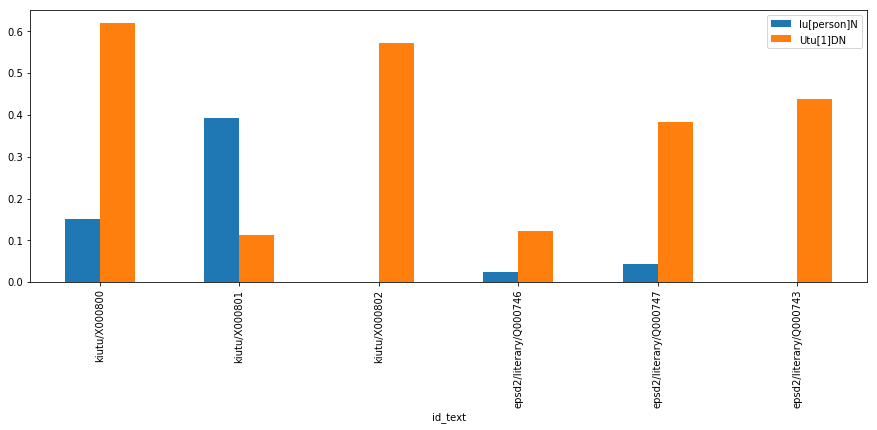

In [83]:
df[["lu[person]N", "Utu[1]DN"]].plot(kind='bar', figsize=(15, 5))

Utu B (epsd2/literary/Q000743) and Utu E (epsd2/literary/Q000746) show respectively the highest TfIdf value for Utu and person (mulu is another word for person) as well, Utu F (epsd2/literary/Q000747) has "mountain" as the highest value.  

Although the word "mountain" is quite common in Sumerian literature, it is interesting to notice its high value (0.468026) in this text. This is verifiable with close reading to the texts as well.
This composition is a dialogue between Utu and his sister Inana, the goddess of love and war. Here Inana asks repeatedly the brother to let her ride to different mountains. Since the text is broken, we don't know really the reasons behind this request. However, this must be the reason why the TfIdf selected this word. However, the relevance of "mountain" the importance has probably been underestimated in previous publications such as Kramer 118.
### 3.2 Comparison between Different Compositions
#### Motive of the Gods
Here I searched for the Sumerian gods of the pantheon, in order to understand which role plays Utu among different literary genres addressed to him.

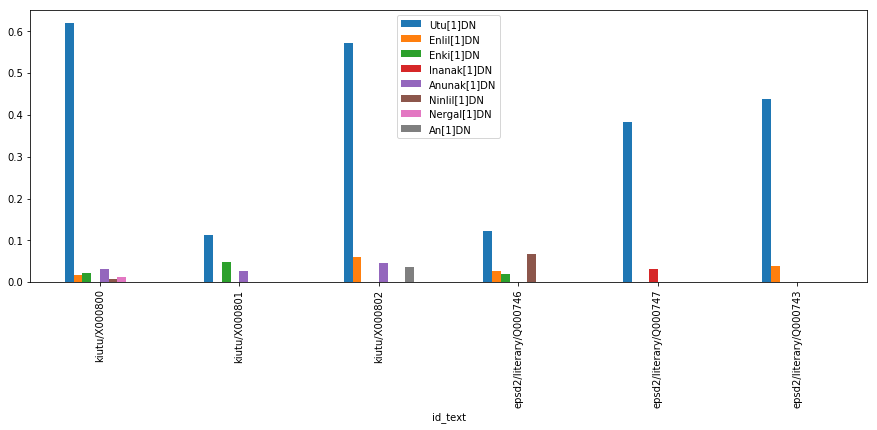

In [84]:
df[["Utu[1]DN", "Enlil[1]DN", "Enki[1]DN", "Inanak[1]DN", "Anunak[1]DN", "Ninlil[1]DN", "Nergal[1]DN", "An[1]DN"]].plot(kind='bar', figsize=(15, 5))

The results here are quite surprising because I expected a higher value for Utu in the Kiutus (first three columns) in comparison to the other genres. Anyway, Kiutu A and Kiutu br 6 have the highest values, and the value of Kiutu br 3 can be attributed to the importance of the patient aforementioned described. I'm still waiting to have the entire corpus of Kiutus, in order to get more definitive results. Anyway, I consider the importance of Utu more relevant in the Kiutus (with the exception of Kiutu br 3) than in other corpora.

I had also expected more similarities between Utu E (epsd2/literary/Q000746) and Utu F (eps2/literary/Q000747) (two Širnamšub). This points to the fact that despite their same label, they present different features.
#### Motive of the Parts of the Universe
The Kiutu prayers (literally "place of the Sun") describe in detail the Mesopotamian universe, and in particular, they describe a precise moment when the Sun is visible in the sky. For this reason, I searched also for lemmas that designate part of the universe.

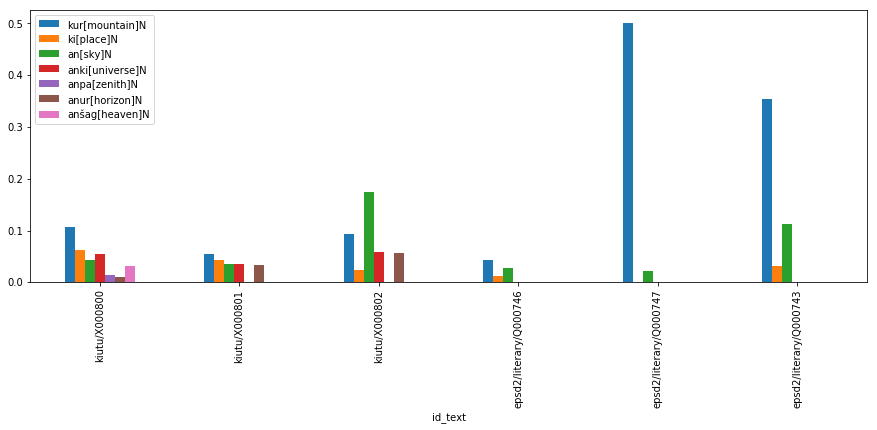

In [85]:
plot2 = df[["kur[mountain]N", "ki[place]N", "an[sky]N", "anki[universe]N", "anpa[zenith]N", "anur[horizon]N", "anšag[heaven]N"]].plot(kind='bar', figsize=(15, 5))

The higher value of Utu F (eps2/literary/Q000747) and Utu B (eps2/literary/Q000743) for "mountain" was quite surprising. The meaning of mountain in Utu F is already mentioned in § 3.1. The same meaning in Utu B can be attributed to the fact that the Sun god is here described as the one who crosses the mountains.

On the other side, the Kiutus present a broader range of words for part of the universe (e.g. universe, zenith, horizon, heaven), many of which are missing in the other texts. This confirms the relevance of the topic "universe" in the Kiutus.

## Conclusions and Next Steps
Natural language analysis can be effective to identify literary themes in different literary genres, as in the described cases. However, we must be aware of some difficulties in working with Sumerian literary texts.
- As already mentioned, several texts are broken (such as Utu B and Utu F) and this may affect the TfIdf vectorizer, as well as other natural language processes.
- The corpora are not complete, many texts lack because they are not published at all and the available editions of texts in ETCSL are in some cases too old and inaccurate.
- The process of lemmatization is in some cases subjective and it depends on the editor because the interpretation of many words is still disputed among the scholars.
- Many natural language tools cannot be applied because of a cultural gap: Sentiment analysis and WordNet are hardly applicable to Sumerian, because of the uncertain meaning of too many lemmas.

Despite these difficulties, computational literary analysis applied to this field can be effective, especially considering the speed with which it is possible to test hypotheses. Despite the almost completely absence of computational literary analysis in Sumerology, the latter is, for now, an emerging but promising field.

## Bibliography
- Baragli, Beatrice. Sonnengrüße. *Die sumerischen Kiutu-Gebetsbeschwörungen*. In preparation.
- Kramer, Samuel Noah. “BM 23631: Bread for Enlil, Sex for Inanna.” *Orientalia Nova Serie*, vol. 54, 1985, pp. 117-132.
- Veldhuis, Niek. "Compass." Github, 1 Aug. 2019, github.com/niekveldhuis/compass/blob/master/2_1_Data_Acquisition_ORACC/2_1_3_extended_ORACC-JSON_parser.ipynb